In [1]:
%load_ext autoreload
%autoreload 2
import pickle
import numpy as np
from tqdm import tqdm
import torch
from torch.utils.data import DataLoader
import IPython.display as ipd
import pyximport
pyximport.install()
%load_ext Cython
import sigkernel as ksig
from utils.data import *
from model.generators import *

In [2]:
hist_len = 8
sample_len = 32
noise_dim = 4
seq_dim = 3
scale = 1.
stride = 800
dpitch_range = 24
folder = 'theorytab'

sigma = 1.0
kernel_type = 'truncated'
dyadic_order = 3
n_levels = 5
order = 1

batch_size = 64
activation = 'Tanh'
hidden_size = 128
conv_kernel_size = 4
conv_stride = 1
n_transformer_layers = 1
n_head = 2
n_channels = 32

epochs = 500
patience = 100

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')

In [3]:
# with open(f'./data/dataframes/{folder}/melodies_beats_min_5_unique_max_range_24.pkl', 'rb') as f:
with open(f'./data/dataframes/{folder}/melodies_beats_min_5_unique_max_range_24_spec_cluster_12.pkl', 'rb') as f:
# with open(f'./data/dataframes/{folder}/all_melodies_within_key_beats_aligned_min_5_unique_max_range_21.pkl', 'rb') as f:
    songs = pickle.load(f)
len(songs)

7267

In [4]:
songs[0][1:]

('imai-asami', 'corpse-party---shangri-la', 'chorus_symbol_key.mid', 10)

In [5]:
cluster_labels = [item[-1] for item in songs]
unique_labels, counts = np.unique(cluster_labels, return_counts=True)
unique_labels.shape, counts

((12,),
 array([ 904,  789,  455,  756,  544, 1173,  689,    4,  684,  407,  776,
          86]))

In [6]:
# separate the dataframes by cluster
df_clusters = []
for i in range(unique_labels.shape[0]):
    df_clusters.append([item for item in songs if item[-1] == i])
    print(i, len(df_clusters[-1]))

0 904
1 789
2 455
3 756
4 544
5 1173
6 689
7 4
8 684
9 407
10 776
11 86


In [7]:
lens = [len(item[0]) for item in songs]
print('Max length:', max(lens))
stride = max(lens) + 1 # ensures no sampling from middle of song

Max length: 394


In [8]:
# gap_dur_dpitch_dfs = gap_duration_deltapitch_transform([item[0] for item in songs])
# max_dpitches = [np.max(np.abs(df['DeltaPitch'])) for df in gap_dur_dpitch_dfs]
# np.max(max_dpitches)

In [8]:
# gap_dur_dpitch_dfs = gap_duration_deltapitch_transform([item[0] for item in songs])
# clusters = [item[4] for item in songs]
# dataset = GapDurationDeltaPitchDataset(gap_dur_dpitch_dfs, sample_len=sample_len, scale=scale, stride=stride, clusters=clusters)

cluster_idx = 5
gap_dur_dpitch_dfs = gap_duration_deltapitch_transform([item[0] for item in df_clusters[cluster_idx]])

# gap_dur_dpitch_dfs = gap_duration_deltapitch_transform([item[0] for item in songs])

dataset = GapDurationDeltaPitchDataset(gap_dur_dpitch_dfs, sample_len=sample_len, scale=scale, stride=stride)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)
len(dataset), len(dataloader)

(1144, 17)

In [9]:
if kernel_type == 'truncated':
    static_kernel = ksig.static.kernels.RationalQuadraticKernel(sigma=sigma)
    kernel = ksig.kernels.SignatureKernel(n_levels=n_levels, order=order, normalization=0, static_kernel=static_kernel, device_ids=None)
elif kernel_type == 'pde':
    static_kernel = ksig.sigkernelpde.RationalQuadraticKernel(sigma=sigma, alpha=1.0)
    kernel = ksig.sigkernelpde.SigKernelPDE(static_kernel, dyadic_order)

In [10]:
generator = TransPredict(noise_dim, seq_dim, sample_len, hist_len, dpitch_range, # data related
                             kernel_size=conv_kernel_size, stride=conv_stride, n_channels=n_channels, # conv layers
                             n_head=n_head, n_transformer_layers=n_transformer_layers, # transformer layers
                             hidden_size=hidden_size, activation=activation)
# generator = generator.cuda()
optimizer = torch.optim.Adam(generator.parameters(), lr=0.001, weight_decay=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=patience, factor=0.5, verbose=True)

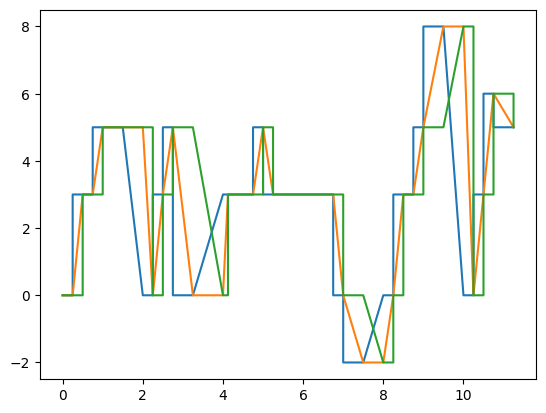

In [40]:
for items in dataloader:
    X, _ = items
    # plt.plot(X[0, :, 0], X[0, :, 1])
    # X = batch_lead_lag_transform(X[:,:,2:], X[:,:,:2], [1])
    # print(X.shape, torch.cat((X[:,:,:2], X[:,:,3:]), dim=-1).shape)
    # Y = batch_rectilinear_with_gap_transform(torch.cat((X[:,:,:2], X[:,:,3:]), dim=-1))
    X = batch_rectilinear_with_gap_transform(X[:,:,:3])
    X = batch_lead_lag_transform(X[:,:,1:], X[:,:,:1], [1,2])
    plt.plot(X[0, :, 0], X[0, :, 1])
    plt.plot(X[0, :, 0], X[0, :, 2])
    plt.plot(X[0, :, 0], X[0, :, 3])
    # plt.show()

    # plt.plot(Y[0, :, 0], Y[0, :, 1])
    break

In [23]:
X[0]

tensor([[ 0.0000,  0.5000,  0.0000,  0.0000],
        [ 0.0000,  0.2500, -2.0000,  0.0000],
        [ 0.0000,  0.2500, -2.0000, -2.0000],
        [ 0.0000,  0.5000,  2.0000, -2.0000],
        [ 0.0000,  0.5000, -7.0000,  2.0000],
        [ 0.0000,  0.5000,  5.0000, -7.0000],
        [ 0.0000,  0.2500, -1.0000,  5.0000],
        [ 0.0000,  0.2500, -2.0000, -1.0000],
        [ 0.0000,  0.5000,  2.0000, -2.0000],
        [ 0.0000,  0.5000,  3.0000,  2.0000],
        [ 0.0000,  0.5000,  2.0000,  3.0000],
        [ 0.0000,  0.2500, -2.0000,  2.0000],
        [ 0.0000,  0.2500, -2.0000, -2.0000],
        [ 0.0000,  0.5000,  2.0000, -2.0000],
        [ 0.0000,  0.5000,  5.0000,  2.0000],
        [ 0.0000,  0.5000,  0.0000,  5.0000],
        [ 0.0000,  0.2500, -1.0000,  0.0000],
        [ 0.0000,  0.2500, -2.0000, -1.0000],
        [ 0.0000,  1.0000,  2.0000, -2.0000],
        [ 0.0000,  0.5000,  1.0000,  2.0000],
        [ 0.0000,  0.2500, -1.0000,  1.0000],
        [ 0.0000,  0.2500,  1.0000

In [17]:
for epoch in range(epochs):
    losses = []
    for batch_num, items in enumerate(tqdm(dataloader)):
        # X, title, cluster = items
        # cluster = cluster.to(device).unsqueeze(-1)
        X, title = items

        for i in range(X.shape[1]-hist_len-1):
            noise = torch.randn(X.shape[0], 1, noise_dim, device=device)
            # print(X.shape, X[:,i:i+hist_len].shape, noise.shape)
            Y = generator(X[:,i:i+hist_len].to(device), noise)
            label = (X[:,i+hist_len,-1]+24).to(torch.long).to(device)
            # compute loss
            optimizer.zero_grad()
            # print(Y.shape, label.shape)
            loss = torch.nn.CrossEntropyLoss()(Y.squeeze(), label.squeeze())

            # backpropagate and update weights
            loss.backward()
            optimizer.step()
            losses.append(loss.cpu().item())

    # log epoch loss and plot generated samples
    epoch_loss = np.average(losses) # average batch mmd for epoch
    scheduler.step(epoch_loss)
    print(f'Epoch {epoch+1}, loss: {epoch_loss}')

  0%|          | 0/13 [00:00<?, ?it/s]

100%|██████████| 13/13 [00:00<00:00, 15.53it/s]


Epoch 1, loss: 2.786592064892568


100%|██████████| 13/13 [00:00<00:00, 16.09it/s]


Epoch 2, loss: 2.7694444616502745


100%|██████████| 13/13 [00:00<00:00, 16.08it/s]


Epoch 3, loss: 2.764156826363758


100%|██████████| 13/13 [00:00<00:00, 16.08it/s]


Epoch 4, loss: 2.759681688104585


100%|██████████| 13/13 [00:00<00:00, 15.93it/s]


Epoch 5, loss: 2.760373378677113


100%|██████████| 13/13 [00:00<00:00, 16.27it/s]


Epoch 6, loss: 2.76080180729512


100%|██████████| 13/13 [00:00<00:00, 16.11it/s]


Epoch 7, loss: 2.757337103719297


100%|██████████| 13/13 [00:00<00:00, 16.37it/s]


Epoch 8, loss: 2.754996585208038


100%|██████████| 13/13 [00:00<00:00, 16.31it/s]


Epoch 9, loss: 2.7563684895684486


100%|██████████| 13/13 [00:00<00:00, 15.24it/s]


Epoch 10, loss: 2.7540392237762146


100%|██████████| 13/13 [00:00<00:00, 16.20it/s]


Epoch 11, loss: 2.7527599789227133


100%|██████████| 13/13 [00:00<00:00, 16.48it/s]


Epoch 12, loss: 2.75179720562836


100%|██████████| 13/13 [00:00<00:00, 16.64it/s]


Epoch 13, loss: 2.7522789945570523


100%|██████████| 13/13 [00:00<00:00, 16.73it/s]


Epoch 14, loss: 2.749714464646917


100%|██████████| 13/13 [00:00<00:00, 16.69it/s]


Epoch 15, loss: 2.747200162115703


100%|██████████| 13/13 [00:00<00:00, 17.15it/s]


Epoch 16, loss: 2.7461531871935994


100%|██████████| 13/13 [00:00<00:00, 16.82it/s]


Epoch 17, loss: 2.7447848048895898


100%|██████████| 13/13 [00:00<00:00, 16.34it/s]


Epoch 18, loss: 2.7428018265344627


100%|██████████| 13/13 [00:00<00:00, 16.06it/s]


Epoch 19, loss: 2.7418808953020486


100%|██████████| 13/13 [00:00<00:00, 16.74it/s]


Epoch 20, loss: 2.7418505268352087


100%|██████████| 13/13 [00:00<00:00, 17.02it/s]


Epoch 21, loss: 2.7399418226452577


  8%|▊         | 1/13 [00:00<00:01,  8.71it/s]


KeyboardInterrupt: 

# Evaluation

In [ ]:
# generator.load_state_dict(torch.load(f'./data/weights/gapdurdpitch_{noise_dim}z_{sample_len}l_{hist_len}h_{key}_{n_levels}m_{order}o_{hidden_size}u_{n_layers}lstm.pt'))

### Sample and play MIDI

In [ ]:
X_titles = []
for arg in title:
    X_titles.append((songs[arg.item()][1], songs[arg.item()][2], songs[arg.item()][3]))
start_pitch = 60
X[:,:,-1] /= scale
Y[:,:,-1] /= scale
X_dfs = batch_gap_duration_pitch_to_df(X, start_pitch=start_pitch)
Y_dfs = batch_gap_duration_pitch_to_df(Y, start_pitch=start_pitch)

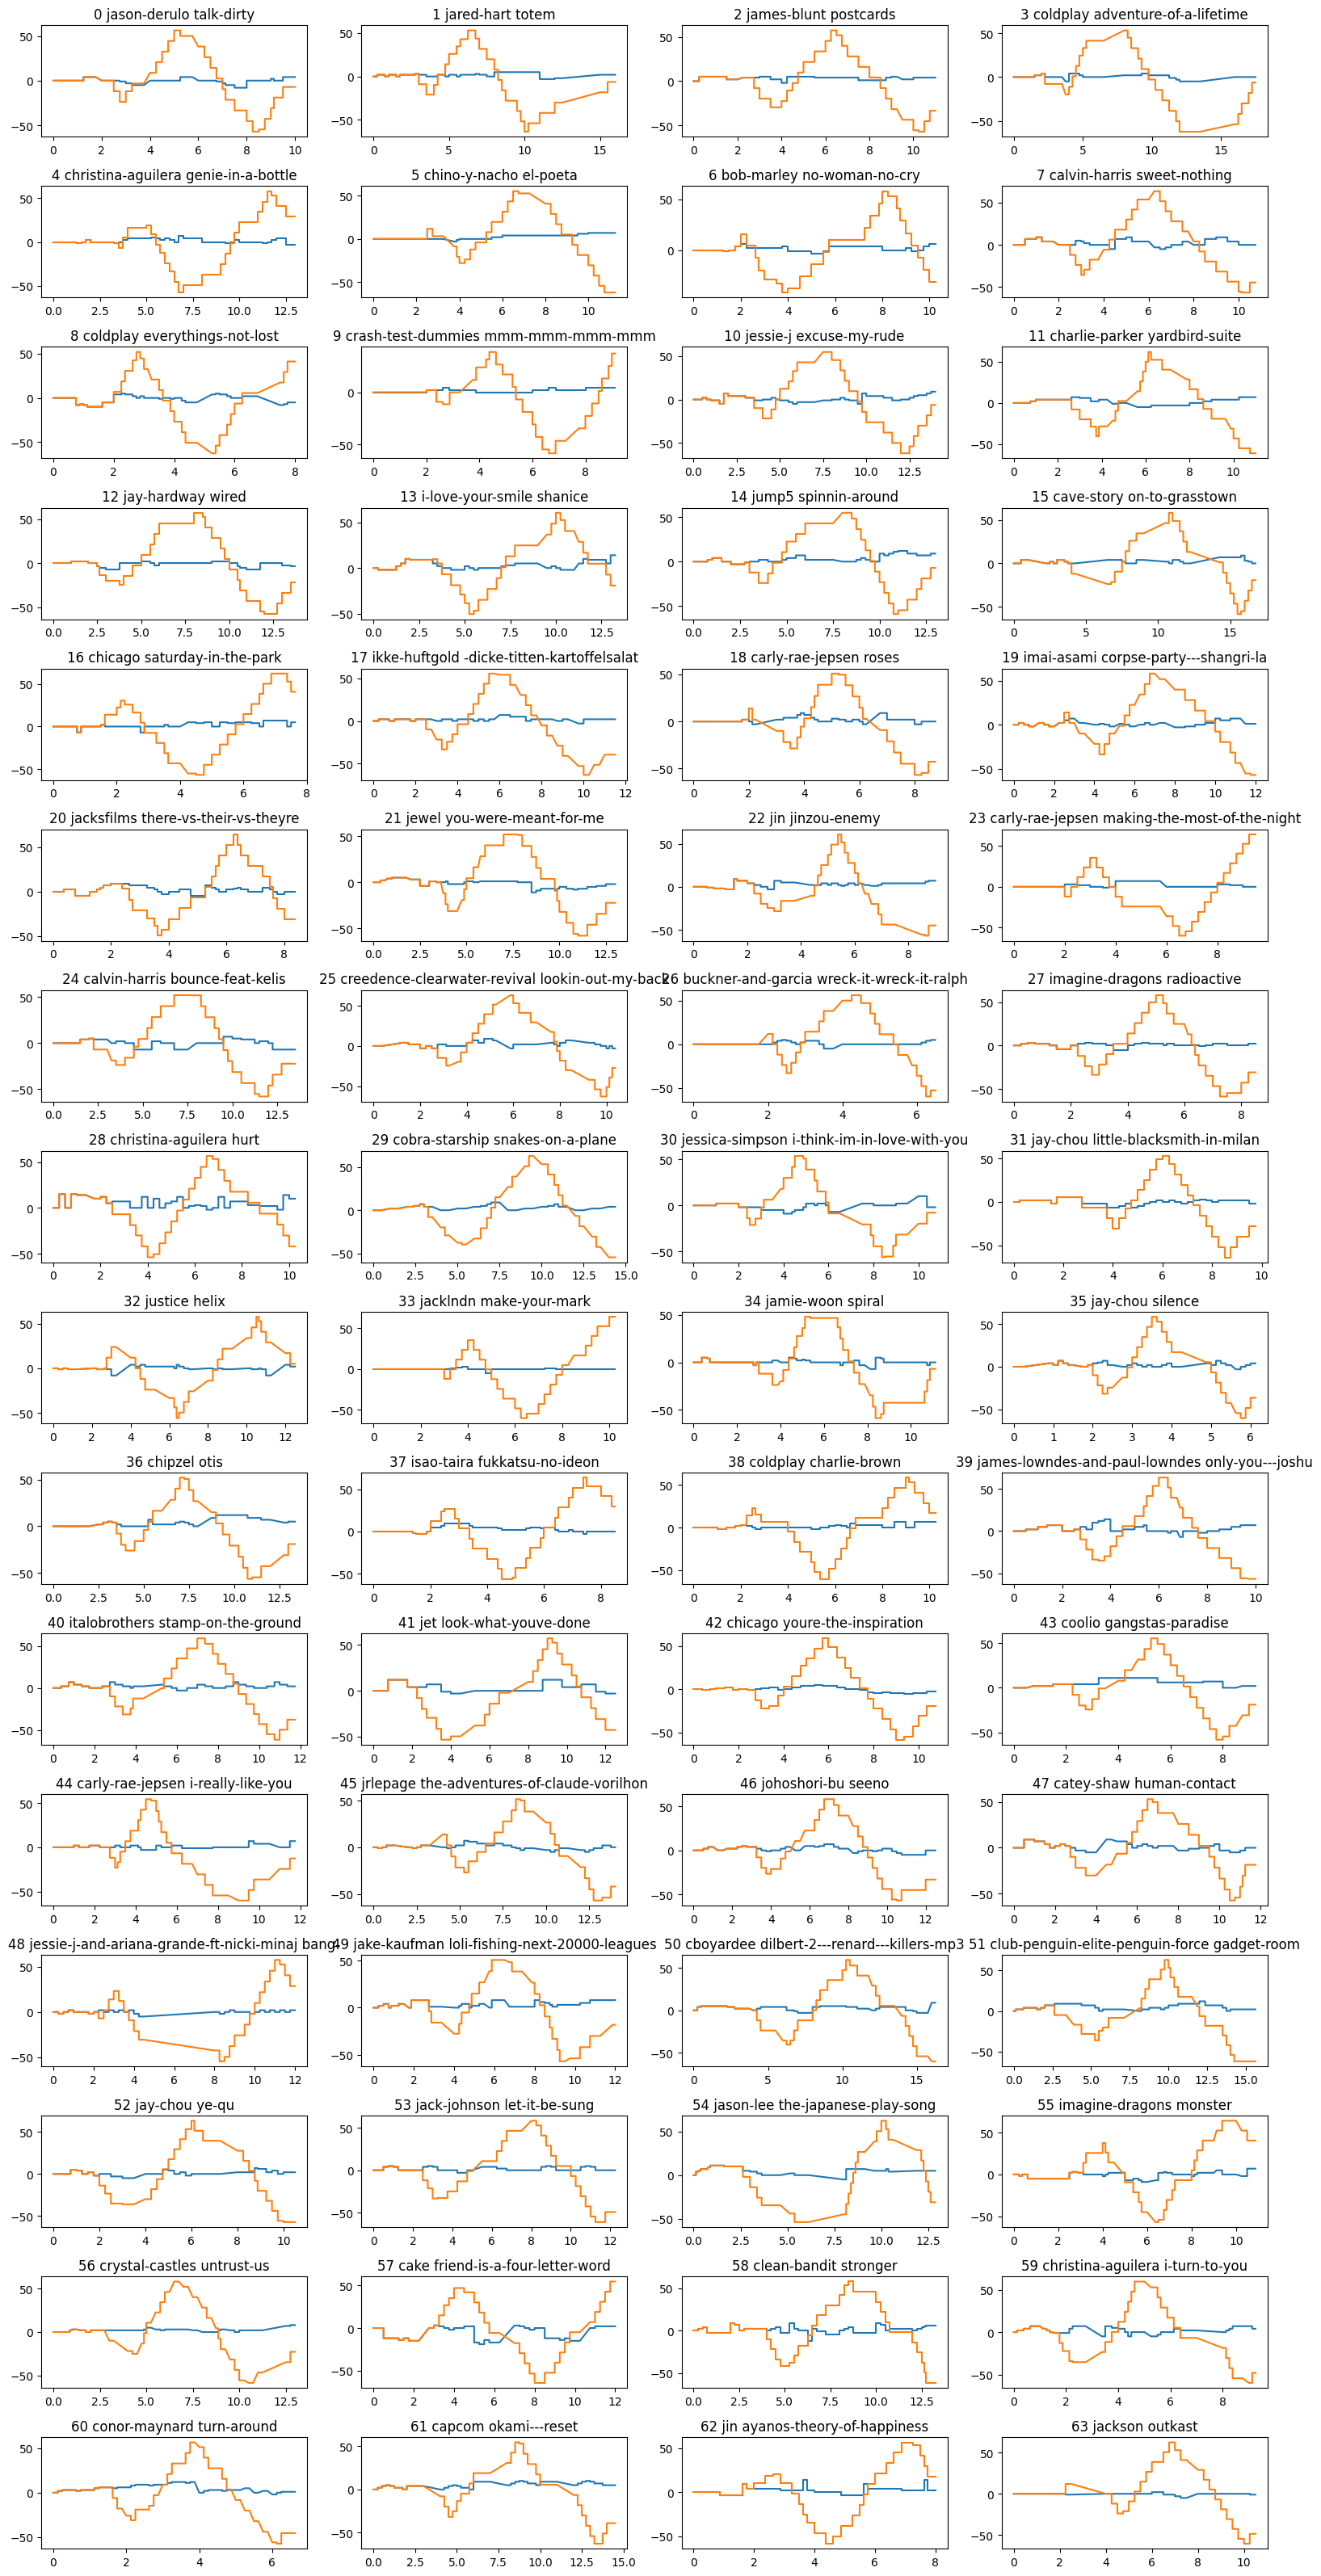

In [ ]:
np_X_rect = batch_rectilinear_with_gap_transform(X).cpu().numpy()
np_Y_rect = batch_rectilinear_with_gap_transform(Y).detach().cpu().numpy()
fig, ax = plt.subplots(batch_size//4, 4, figsize=(16, batch_size//2))
for i in range(batch_size//4):
    for j in range(4):
        if batch_size//4 == 1:
            ax[j].plot(np_X_rect[j,:,0], np_X_rect[j,:,1]/scale)
            ax[j].plot(np_Y_rect[j,:,0], np_Y_rect[j,:,1]/scale)
            ax[j].set_title((f'{j} {X_titles[j][0]} {X_titles[j][1]}')[:50])
        else:
            ax[i, j].plot(np_X_rect[i*4+j,:,0], np_X_rect[i*4+j,:,1]/scale)
            ax[i, j].plot(np_Y_rect[i*4+j,:,0], np_Y_rect[i*4+j,:,1]/scale)
            ax[i, j].set_title((f'{i*4+j} {X_titles[i*4+j][0]} {X_titles[i*4+j][1]}')[:50])
plt.tight_layout()

In [ ]:
sample_idx = 0
print(X_titles[sample_idx])

('jamie-lawson', 'wasnt-expecting-that', 'chorus_symbol_key.mid')


In [ ]:
input_midi = df_to_midi(X_dfs[sample_idx])
output_midi = df_to_midi(Y_dfs[sample_idx])

In [ ]:
pd.merge(X_dfs[sample_idx][['Start', 'End', 'Pitch']], Y_dfs[sample_idx][['Pitch']], left_index=True, right_index=True)

Start    End  Pitch_x  Pitch_y
0    0.00   0.50     60.0     60.0
1    0.50   1.00     64.0     64.0
2    1.00   1.50     67.0     67.0
3    1.50   2.00     69.0     69.0
4    2.00   2.25     60.0     60.0
5    2.25   2.75     60.0     60.0
6    2.75   3.25     64.0     64.0
7    3.25   3.50     67.0     67.0
8    3.50   4.50     69.0     64.0
9    4.75   5.00     60.0     59.0
10   5.00   5.50     60.0     65.0
11   5.50   5.75     60.0     79.0
12   5.75   6.25     57.0     68.0
13   6.25   6.50     60.0     59.0
14   6.50   7.00     62.0     57.0
15   7.00   7.25     64.0     73.0
16   7.25   8.50     62.0     63.0
17   8.75   9.00     60.0     49.0
18   9.00   9.25     64.0     45.0
19   9.25   9.50     67.0     60.0
20   9.50   9.75     69.0     73.0
21   9.75  10.00     69.0     58.0
22  10.00  10.25     60.0     56.0
23  10.25  10.50     60.0     55.0
24  10.50  10.75     64.0     64.0
25  10.75  11.00     64.0     50.0
26  11.00  11.25     67.0     36.0
27  11.25  12.00     69.0     43.0
28  12.25  12.50     64.0     57.0
29  12.50  12.75     62.0     67.0
30  12.75  13.00     60.0     52.0
31  13.00  13.25     60.0     59.0

In [ ]:
fs=44100
audio_data = input_midi.fluidsynth(fs=fs, sf2_path='./data/soundfonts/Steinway_Grand_Piano_1.2.sf2')
ipd.Audio(audio_data, rate=fs)

In [ ]:
fs=44100
audio_data = output_midi.fluidsynth(fs=fs, sf2_path='./data/soundfonts/Steinway_Grand_Piano_1.2.sf2')
ipd.Audio(audio_data, rate=fs)

### Evaluate note within key percentages

In [ ]:
Xs = []
Ys = []
for item in dataloader:
    X, title = item
    Xs.append(X)
    X = X.to(device)
    X_rect = batch_rectilinear_with_gap_transform(X[:, hist_len:, :])

    noise = torch.randn(X.shape[0], X.shape[1]-1, noise_dim).to(device)
    Y = generator(noise, X[:, :hist_len, :], X[:, hist_len:, :2])
    Ys.append(Y.detach().cpu())
    Y_rect = batch_rectilinear_with_gap_transform(Y[:, hist_len:, :])

Xs = torch.cat(Xs, dim=0)
Ys = torch.cat(Ys, dim=0)
print(Xs.shape, Ys.shape)
all_X_dfs = batch_gap_duration_pitch_to_df(Xs, start_pitch=start_pitch)
all_Y_dfs = batch_gap_duration_pitch_to_df(Ys, start_pitch=start_pitch)

TypeError: TransInc.forward() takes 3 positional arguments but 4 were given

In [ ]:
key_to_note = {0: 'C', 1: 'C#', 2: 'D', 3: 'D#', 4: 'E', 5: 'F', 6: 'F#', 7: 'G', 8: 'G#', 9: 'A', 10: 'A#', 11: 'B'}
key_notes = []
for i in range(12):
    key_notes.append(get_notes_from_major_scale(i))

In [ ]:
# check percentage of notes in C major scale
X_key_percentages = {0: [], 1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7: [], 8: [], 9: [], 10: [], 11: []}
Y_key_percentages = {0: [], 1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7: [], 8: [], 9: [], 10: [], 11: []}
for df in all_X_dfs:
    for i in range(len(key_notes)):
        percentage = len([note for note in df['Pitch'].values if note in key_notes[i]]) / len(df['Pitch'].values)
        X_key_percentages[i].append(percentage)
for df in all_Y_dfs:
    for i in range(len(key_notes)):
        percentage = len([note for note in df['Pitch'].values if note in key_notes[i]]) / len(df['Pitch'].values)
        Y_key_percentages[i].append(percentage)

Key: C
Mean percentage of notes in key C: 0.9286733774038461
Mean percentage of notes in key C#: 0.4685246394230769
Mean percentage of notes in key D: 0.5457857572115384
Mean percentage of notes in key D#: 0.7462064302884616
Mean percentage of notes in key E: 0.2827899639423077
Mean percentage of notes in key F: 0.9157902644230769
Mean percentage of notes in key F#: 0.1749549278846154
Mean percentage of notes in key G: 0.87158203125
Mean percentage of notes in key G#: 0.5461989182692307
Mean percentage of notes in key A: 0.46766075721153844
Mean percentage of notes in key A#: 0.8043118990384616
Mean percentage of notes in key B: 0.24752103365384615


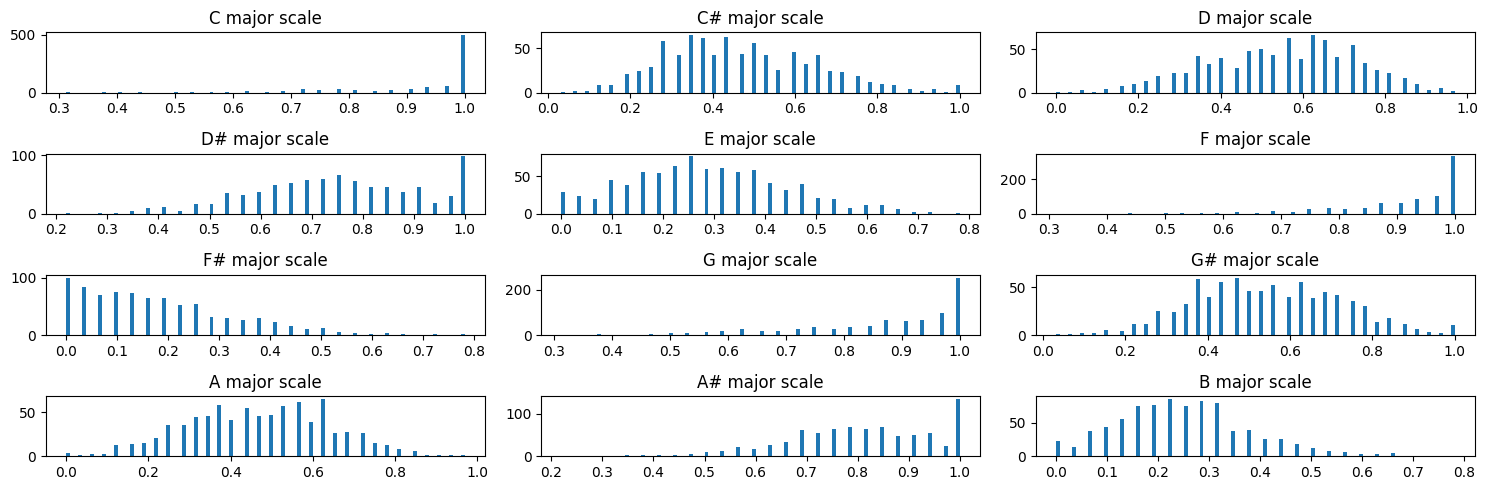

In [ ]:
fig, ax = plt.subplots(4, 3, figsize=(15, 5))
print(f'Key: {key_to_note[start_pitch % 12]}')
for i in range(len(key_notes)):
    print(f'Mean percentage of notes in key {key_to_note[i]}: {np.mean(X_key_percentages[i])}')
    ax[i//3, i%3].hist(X_key_percentages[i], bins=100)
    ax[i//3, i%3].set_title(f'{key_to_note[i]} major scale')
plt.tight_layout()

Key: C
Mean percentage of notes in key C: 0.68359375
Mean percentage of notes in key C#: 0.5896559495192307
Mean percentage of notes in key D: 0.5729417067307693
Mean percentage of notes in key D#: 0.6323993389423077
Mean percentage of notes in key E: 0.47618689903846156
Mean percentage of notes in key F: 0.6459585336538461
Mean percentage of notes in key F#: 0.4512469951923077
Mean percentage of notes in key G: 0.6631610576923077
Mean percentage of notes in key G#: 0.5991962139423077
Mean percentage of notes in key A: 0.5583683894230769
Mean percentage of notes in key A#: 0.6466346153846154
Mean percentage of notes in key B: 0.4806565504807692


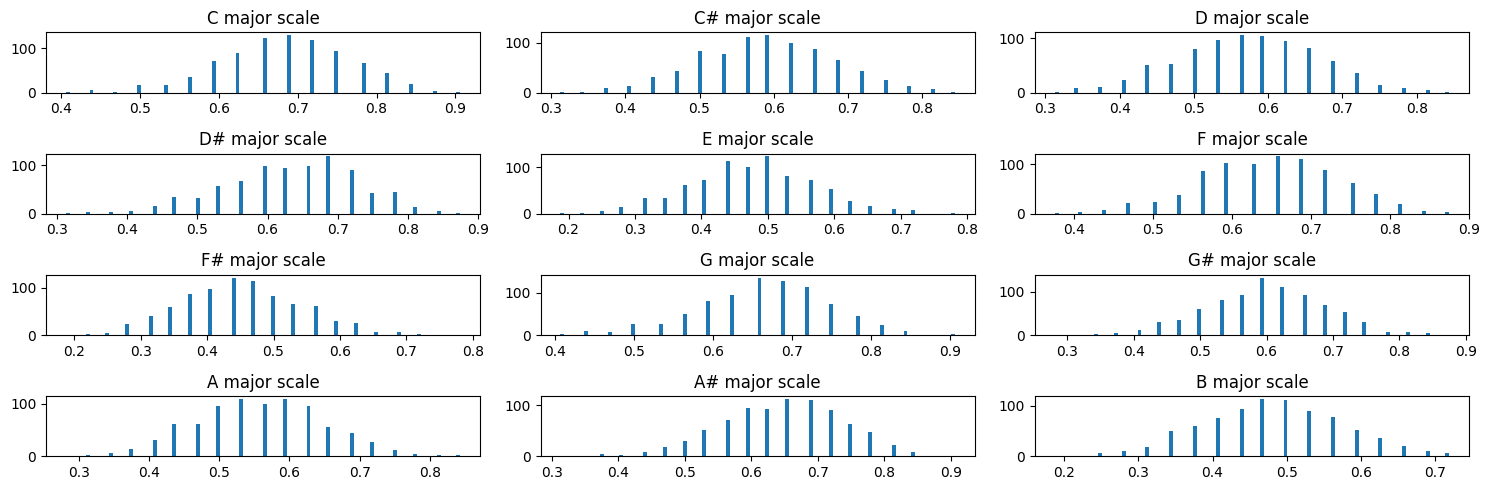

In [ ]:
fig, ax = plt.subplots(4, 3, figsize=(15, 5))
print(f'Key: {key_to_note[start_pitch % 12]}')
for i in range(len(key_notes)):
    print(f'Mean percentage of notes in key {key_to_note[i]}: {np.mean(Y_key_percentages[i])}')
    ax[i//3, i%3].hist(Y_key_percentages[i], bins=100)
    ax[i//3, i%3].set_title(f'{key_to_note[i]} major scale')
plt.tight_layout()